**Target:**
*  Reduced the kernels, at few layers, to reduce the parameters.

**Results:**
*  Parameters: 13,326
*  Best Training Accuracy: 99.88
*  Best Test Accuracy: 99.27

**Analysis:**
*  Parameters reduced
* Observing a bit consistent validation accuracy in the end



In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(8)) #input -28x28x1 OUtput - 26x26x8 
        self.conv2 = nn.Sequential(nn.Conv2d(8, 12, 3, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(12))   #input -26x26x8 OUtput - 24x24x12
        self.conv3 = nn.Sequential(nn.Conv2d(12, 16, 3, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(16))  #input -24x24x12 OUtput - 22x22x16 


        self.conv4 = nn.Sequential(nn.Conv2d(16, 8, 1, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(8)) #input -22x22x16 OUtput - 22x22x8 
        self.pool1 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))  #input - 22x22x8 OUtput - 11x11x8 

        self.conv5 = nn.Sequential(nn.Conv2d(8, 16, 3, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(16))  #input -11x11x8 OUtput - 9x19x16

        self.conv6 = nn.Sequential(nn.Conv2d(16, 8, 1, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(8)) #input -9x9x16 OUtput - 9x9x8 
        
        self.conv7 = nn.Sequential(nn.Conv2d(8, 16, 3, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(16))   #input -9x9x8 OUtput - 7x7x16 
        
        self.conv8 = nn.Sequential(nn.Conv2d(16, 10, 7))   #input -7x7x16 OUtput - 1x1x10 

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool1(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)        
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             876
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
            Conv2d-7           [-1, 16, 22, 22]           1,744
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
           Conv2d-10            [-1, 8, 22, 22]             136
             ReLU-11            [-1, 8, 22, 22]               0
      BatchNorm2d-12            [-1, 8, 22, 22]              16
        MaxPool2d-13            [-1, 8, 11, 11]               0
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH : ",epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH :  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.04687246307730675 Batch_id=468 Accuracy=95.63: 100%|██████████| 469/469 [00:12<00:00, 37.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9856/10000 (98.56%)

EPOCH :  1


Loss=0.020576396957039833 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:12<00:00, 38.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9896/10000 (98.96%)

EPOCH :  2


Loss=0.007229313254356384 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:12<00:00, 38.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9888/10000 (98.88%)

EPOCH :  3


Loss=0.011109729297459126 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 38.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9901/10000 (99.01%)

EPOCH :  4


Loss=0.01278182864189148 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:12<00:00, 37.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9865/10000 (98.65%)

EPOCH :  5


Loss=0.02457391656935215 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:12<00:00, 38.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9919/10000 (99.19%)

EPOCH :  6


Loss=0.05498070642352104 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:12<00:00, 38.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9920/10000 (99.20%)

EPOCH :  7


Loss=0.04498592019081116 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:12<00:00, 38.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9919/10000 (99.19%)

EPOCH :  8


Loss=0.004936168435961008 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:12<00:00, 38.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9916/10000 (99.16%)

EPOCH :  9


Loss=0.014575168490409851 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:12<00:00, 38.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9924/10000 (99.24%)

EPOCH :  10


Loss=0.01680697500705719 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:12<00:00, 38.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)

EPOCH :  11


Loss=0.014150723814964294 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:12<00:00, 37.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9924/10000 (99.24%)

EPOCH :  12


Loss=0.00103146827314049 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:12<00:00, 38.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9915/10000 (99.15%)

EPOCH :  13


Loss=0.0025848050136119127 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:12<00:00, 38.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9927/10000 (99.27%)

EPOCH :  14


Loss=0.01906171441078186 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:12<00:00, 38.35it/s]



Test set: Average loss: 0.0255, Accuracy: 9927/10000 (99.27%)



Text(0.5, 1.0, 'Test Accuracy')

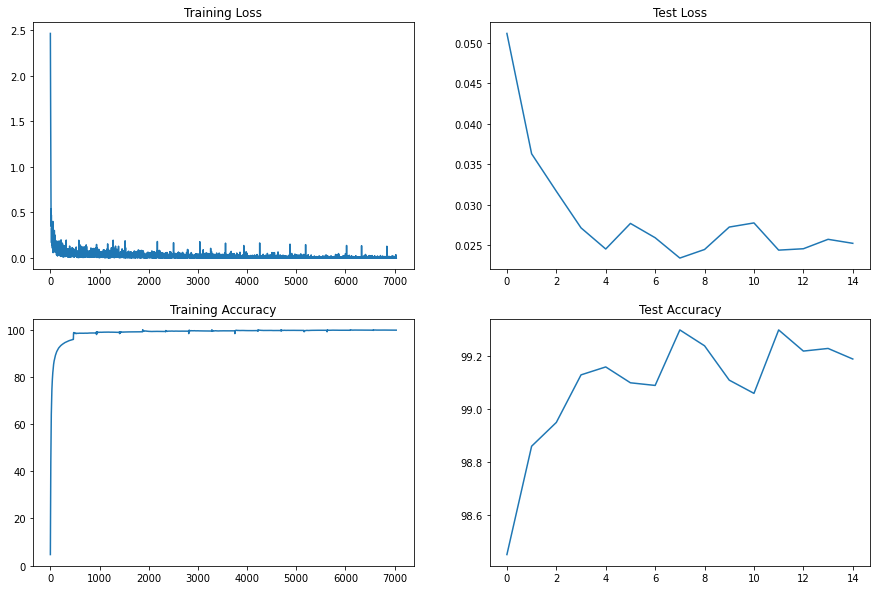

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")